In [2]:
import sys
sys.path.append("../")

import jax
import jax.numpy as np
from functools import partial
import jraph
from jax_md import space, partition

from models.graph_utils import nearest_neighbors, nearest_neighbors_ann, RadiusSearch

In [3]:
rng = jax.random.PRNGKey(42)

n_nodes = 5000
k = 10
n_batch = 4
n_pos = 3

x = np.load("/n/holyscratch01/iaifi_lab/ccuesta/data_for_sid/halos.npy")[:n_batch, :n_nodes,:n_pos]

## Brute force kNN

In [35]:
sources, targets = nearest_neighbors(x[0], k=k)
sources_ann, targets_ann = nearest_neighbors_ann(x[0], k=k)

In [4]:
np.array_equal(sources_ann, sources), np.array_equal(targets_ann, targets)

(Array(True, dtype=bool), Array(False, dtype=bool))

In [5]:
(targets_ann == targets).sum()

Array(28243, dtype=int32)

In [6]:
%%timeit
sources_ann, targets_ann = nearest_neighbors_ann(x[0], k=k)

4.89 ms ± 1.71 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [7]:
%%timeit
sources, targets = nearest_neighbors(x[0], k=k)

7.05 ms ± 696 ns per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Using jax-md

Scale up without having to recalculate pairwise distance matrix. Let's see if it can scale to 50000 nodes.

In [8]:
ns = RadiusSearch(box_size=1000., cutoff=30.)
nbr = ns.init_neighbor_lst(x[0])

In [9]:
%%timeit
nbr_update, _ = ns.update_neighbor_lst(x, nbr)

60.9 ms ± 1.78 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [10]:
nbr_update, nbr = ns.update_neighbor_lst(x, nbr)

In [11]:
nbr_update.idx

Array([[[   0,  331,    1, ..., 5000, 5000, 5000],
        [   0,    0,    1, ..., 5000, 5000, 5000]],

       [[   0, 1379,    1, ..., 5000, 5000, 5000],
        [   0,    0,    1, ..., 5000, 5000, 5000]],

       [[   0, 3839,    1, ..., 5000, 5000, 5000],
        [   0,    0,    1, ..., 5000, 5000, 5000]],

       [[   0, 4977, 4138, ..., 5000, 5000, 5000],
        [   0,    0,    0, ..., 5000, 5000, 5000]]], dtype=int32)

In [12]:
# Shape [batch, (senders, receivers), -1]
nbr_update.idx.shape

(4, 2, 29868)

## Use in graph

In [13]:
from typing import Callable
import flax.linen as nn
import jax.numpy as jnp

from models.mlp import MLP


def get_node_mlp_updates(mlp_feature_sizes: int) -> Callable:
    """Get a node MLP update  function

    Args:
        mlp_feature_sizes (int): number of features in the MLP

    Returns:
        Callable: update function
    """

    def update_fn(
        nodes: jnp.ndarray,
        sent_attributes: jnp.ndarray,
        received_attributes: jnp.ndarray,
        globals: jnp.ndarray,
    ) -> jnp.ndarray:
        """update node features

        Args:
            nodes (jnp.ndarray): node features
            sent_attributes (jnp.ndarray): attributes sent to neighbors
            received_attributes (jnp.ndarray): attributes received from neighbors
            globals (jnp.ndarray): global features

        Returns:
            jnp.ndarray: updated node features
        """
        if received_attributes is not None:
            inputs = jnp.concatenate([nodes, received_attributes, globals], axis=1)
        else:
            inputs = jnp.concatenate([nodes, globals], axis=1)
        return MLP(mlp_feature_sizes)(inputs)

    return update_fn

def get_edge_mlp_updates(mlp_feature_sizes: int) -> Callable:
    """Get an edge MLP update function

    Args:
        mlp_feature_sizes (int): number of features in the MLP

    Returns:
        Callable: update function
    """

    def update_fn(
        edges: jnp.ndarray,
        senders: jnp.ndarray,
        receivers: jnp.ndarray,
        globals: jnp.ndarray,
    ) -> jnp.ndarray:
        """update edge features

        Args:
            edges (jnp.ndarray): edge attributes
            senders (jnp.ndarray): senders node attributes
            receivers (jnp.ndarray): receivers node attributes
            globals (jnp.ndarray): global features

        Returns:
            jnp.ndarray: updated edge features
        """
        if edges is not None:
            inputs = jnp.concatenate([edges, senders, receivers, globals], axis=1)
        else:
            inputs = jnp.concatenate([senders, receivers, globals], axis=1)
        return MLP(mlp_feature_sizes)(inputs)
    return update_fn

In [14]:
class GraphConvNet(nn.Module):
    """A simple graph convolutional network"""
    latent_size: int = 32
    num_mlp_layers: int = 3
    message_passing_steps: int = 3
    skip_connections: bool = True
    layer_norm: bool = True

    @nn.compact
    def __call__(self, graphs: jraph.GraphsTuple) -> jraph.GraphsTuple:
        """Do message passing on graph

        Args:
            graphs (jraph.GraphsTuple): graph object

        Returns:
            jraph.GraphsTuple: updated graph object
        """
        in_features = graphs.nodes.shape[-1]
        embedder = jraph.GraphMapFeatures(embed_node_fn=nn.Dense(self.latent_size))
        processed_graphs = embedder(graphs)
        processed_graphs = processed_graphs._replace(
            globals=processed_graphs.globals.reshape(processed_graphs.globals.shape[0], -1),
        )
        
        mlp_feature_sizes = [self.latent_size] * self.num_mlp_layers
        update_node_fn = get_node_mlp_updates(mlp_feature_sizes)
        update_edge_fn = get_edge_mlp_updates(mlp_feature_sizes)

        # Now, we will apply the GCN once for each message-passing round.
        for _ in range(self.message_passing_steps):
            graph_net = jraph.GraphNetwork(
                update_node_fn=update_node_fn,
                update_edge_fn=update_edge_fn,
            )
            if self.skip_connections:
                processed_graphs = add_graphs_tuples(
                    graph_net(processed_graphs), processed_graphs
                )
            else:
                processed_graphs = graph_net(processed_graphs)

            if self.layer_norm:
                processed_graphs = processed_graphs._replace(
                    nodes=nn.LayerNorm()(processed_graphs.nodes),
                )
        return graphs

In [15]:
from models.gnn import add_graphs_tuples

In [16]:
globals = jax.random.normal(rng, (n_batch, 1, 4))
graph = jax.vmap(partition.to_jraph)(nbr_update, mask=None,  nodes=x, edges=None, globals=globals)

In [17]:
graph.n_node.shape, graph.n_edge.shape, graph.nodes.shape, graph.globals.shape, graph.senders.shape, graph.receivers.shape

((4, 2), (4, 2), (4, 5001, 3), (4, 2, 4), (4, 29868), (4, 29868))

In [18]:
class GraphWrapper(nn.Module):
    @nn.compact
    def __call__(self, x):
        model = jax.vmap(GraphConvNet())
        return model(x)

In [19]:
model = GraphWrapper()
graph_update, params  = model.init_with_output(rng, graph)
graph_update.nodes.shape  # Output nodes

(4, 5001, 3)

## k-NN with distances and neighbour distance

In [20]:
import jax
import jax.numpy as np
import jraph
from jax_md import space, partition

from functools import partial


@partial(jax.jit, static_argnums=(1,))
def nearest_neighbors(x, k, mask=None):
    """The shittiest implementation of nearest neighbours with masking in the world"""

    if mask is None:
        mask = np.ones((x.shape[0],), dtype=np.int32)

    n_nodes = x.shape[0]

    distance_matrix = np.sum((x[:, None, :] - x[None, :, :]) ** 2, axis=-1)

    distance_matrix = np.where(mask[:, None], distance_matrix, np.inf)
    distance_matrix = np.where(mask[None, :], distance_matrix, np.inf)
    
    # Get top k indices and corresponding distances
    indices_top_k = np.argsort(distance_matrix, axis=-1)[:, :k]
    distances_top_k = distance_matrix[np.arange(distance_matrix.shape[-1])[:, np.newaxis], indices_top_k]
    distances_mean_nhood = distances_top_k.mean(-1)  # Mean distance in neighbourhood
    
    sources = indices_top_k[:, 0].repeat(k)
    targets = indices_top_k.reshape(n_nodes * (k))

    return (sources, targets)

In [21]:
sources, targets = nearest_neighbors(x[0], k=k)

## k-NN with periodic boundary conditions

In [4]:
@partial(jax.jit, static_argnums=(1,))
def nearest_neighbors(x, k, box_size=None, mask=None):
    """Modified implementation of nearest neighbors with masking and periodic boundary conditions"""

    if mask is None:
        mask = np.ones((x.shape[0],), dtype=np.int32)

    n_nodes = x.shape[0]

    # Compute the vector difference between positions accounting for PBC
    dr = x[:, None, :] - x[None, :, :]

    if box_size is not None:
        dr = dr - box_size * np.round(dr / box_size)

    # Calculate the distance matrix accounting for PBC
    distance_matrix = np.sum(dr ** 2, axis=-1)

    distance_matrix = np.where(mask[:, None], distance_matrix, np.inf)
    distance_matrix = np.where(mask[None, :], distance_matrix, np.inf)

    indices = np.argsort(distance_matrix, axis=-1)[:, :k]

    sources = indices[:, 0].repeat(k)
    targets = indices.reshape(n_nodes * (k))

    return (sources, targets)

In [12]:
import numpy as onp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm

def visualize_3d_graph(positions, senders, receivers):
    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(111, projection='3d')

    # Plot nodes
    ax.scatter(positions[:, 0], positions[:, 1], positions[:, 2], marker='o', c='b', label='Nodes')

    # Plot edges
    for i in tqdm(range(len(senders))):
        sender_idx = senders[i]
        receiver_idx = receivers[i]
        sender_pos = positions[sender_idx]
        receiver_pos = positions[receiver_idx]

        ax.plot([sender_pos[0], receiver_pos[0]],
                [sender_pos[1], receiver_pos[1]],
                [sender_pos[2], receiver_pos[2]],
                c='r', lw=0.5)

    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    ax.legend()

    plt.show()

In [26]:
n_nodes = 100

In [31]:
sources, targets = nearest_neighbors(x=x[0, :n_nodes], k=3, box_size=None, mask=None)
sources, targets;

100%|████████████████████████████████████████| 300/300 [00:02<00:00, 113.20it/s]


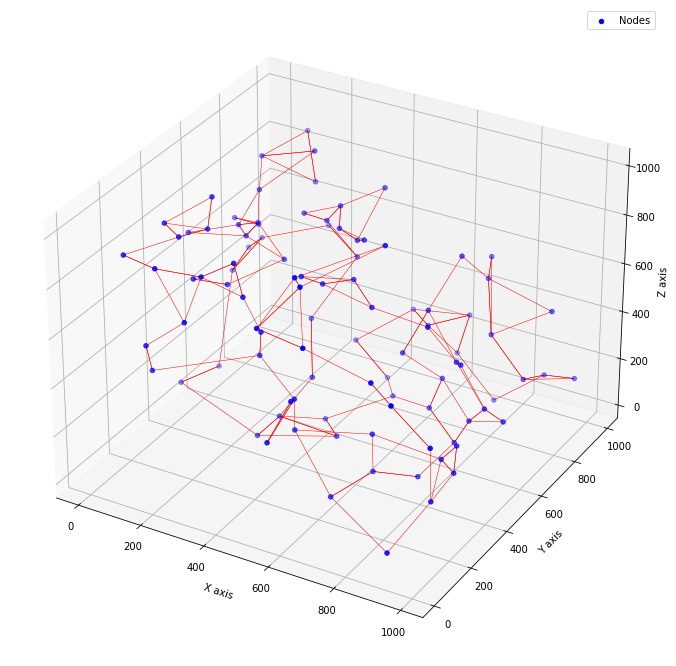

In [32]:
visualize_3d_graph(x[0, :n_nodes], sources, targets)

In [33]:
sources, targets = nearest_neighbors(x=x[0, :n_nodes], k=3, box_size=1000., mask=None)
sources, targets;

100%|████████████████████████████████████████| 300/300 [00:02<00:00, 137.31it/s]


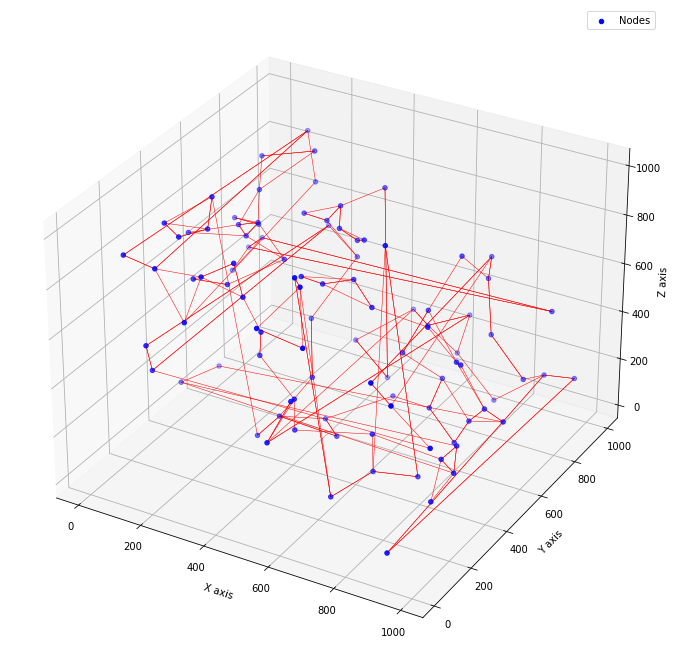

In [34]:
visualize_3d_graph(x[0, :n_nodes], sources, targets)